## Functions Declaration for Converting Coordinates

In [1]:
from pyproj import Proj, transform # Import necessary functions from pyproj library
import re # Import re module for regular expressions

# Function to convert coordinates from NZTM (New Zealand Transverse Mercator) projection to WGS84 (latitude, longitude)
def nztm_to_latlon(easting, northing):
    # Define NZTM (New Zealand Transverse Mercator) projection using <authority>:<code> syntax
    nztm = Proj(init="epsg:2193")  # EPSG code for NZTM
    
    # Define WGS84 (latitude, longitude) projection using <authority>:<code> syntax
    wgs84 = Proj(init="epsg:4326")  # EPSG code for WGS84
    
    # Convert coordinates from NZTM to WGS84
    lon, lat = transform(nztm, wgs84, easting, northing)
    return lat, lon


# Function to extract coordinates
def extract_coordinates(description):
    # Split the description into components
    easting_northing = description.split()

    # Remove any non-numeric characters from the components
    easting = int(re.sub(r'\D', '', easting_northing[0]))  # Remove non-digits (including 'E')
    northing = int(re.sub(r'\D', '', easting_northing[1]))  # Remove non-digits (including 'N')

    return nztm_to_latlon(easting, northing)

## Data Processing

In [2]:
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import warnings  # To handle warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Ignore FutureWarnings

from sklearn.preprocessing import StandardScaler  # Import StandardScaler from scikit-learn

# Load the data from CSV file, explicitly setting the data type for specific columns to string
data = pd.read_csv('Data.csv', dtype={'Column_Name': str}, low_memory=False)

# Remove columns that are entirely null
data = data.dropna(axis=1, how='all')

# Convert 'Count Start Date' column to datetime format, specifying day-first format and coercing errors
data['Count Start Date'] = pd.to_datetime(data['Count Start Date'], dayfirst=True, errors='coerce')

# Get the average traffic volume for weekends
data['Weekend Traffic ADT'] = (data['Saturday Volume'].fillna(0) + data['Sunday Volume'].fillna(0)) / 2

# Filter data to include only records from '2018-02-09' onwards (Data with Location)
filtered_data = data[data['Count Start Date'] >= '2018-02-09']
# Remove rows where 'Description (location of traffic count)' is null
filtered_data = filtered_data.dropna(subset=['Description (location of traffic count)'])

# Apply function to extract coordinates and create new columns 'Latitude' and 'Longitude'
filtered_data[['Latitude', 'Longitude']] = filtered_data['Description (location of traffic count)'].apply(extract_coordinates).apply(pd.Series)

# Display the shape of original and normalized dataframes
print(f"Filtered data shape: {filtered_data.shape}")
print(filtered_data.info())


Filtered data shape: (13024, 26)
<class 'pandas.core.frame.DataFrame'>
Index: 13024 entries, 8771 to 21889
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Area                                     0 non-null      object        
 1   Road Name                                13024 non-null  object        
 2   Carriageway Start Name                   13004 non-null  object        
 3   Carriageway End Name                     13014 non-null  object        
 4   Description (location of traffic count)  13024 non-null  object        
 5   Direction                                13024 non-null  object        
 6   Count Start Date                         13024 non-null  datetime64[ns]
 7   5 Day ADT                                13023 non-null  float64       
 8   7 Day ADT                                13023 non-null  float64       
 9   Saturday

## Create a copy of filtered_data as traffic_data

In [3]:
traffic_data= filtered_data.copy()
print(traffic_data.head())

     Area             Road Name Carriageway Start Name Carriageway End Name  \
8771  NaN  ARNEY RD (WAITAKERE)             SWANSON RD         ROBERTSON RD   
8772  NaN            BARRACK RD               BANKS RD      BERTRAND RD RAB   
8783  NaN    DAIRY FLAT HIGHWAY      KAHIKATEA FLAT RD          URBAN_RURAL   
8784  NaN    DAIRY FLAT HIGHWAY     START PASSING LANE     END PASSING LANE   
8785  NaN    DAIRY FLAT HIGHWAY            URBAN_RURAL            GREENS RD   

     Description (location of traffic count) Direction Count Start Date  \
8771                      E1742733  N5918847      Both       2018-02-09   
8772                      E1763731  N5914484      Both       2018-02-09   
8783                      E1746749  N5942592      Both       2018-02-14   
8784                      E1748737  N5936848      Both       2018-02-16   
8785                      E1746501  N5939870      Both       2018-02-13   

      5 Day ADT  7 Day ADT  Saturday Volume  ...  PM Peak Hour  Car  LCV  

## Standardize Traffic Data for K-Means Clustering

In [4]:
from sklearn.preprocessing import StandardScaler

# Select relevant columns for clustering
selected_columns = ['5 Day ADT', 'Weekend Traffic ADT',
                    'AM Peak Volume', 'Mid Peak Volume', 'PM Peak Volume']

# Handle missing values if any
traffic_data[selected_columns] = traffic_data[selected_columns].fillna(0)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(traffic_data[selected_columns])


## Find the best k for K Means clustering using the elbow method.

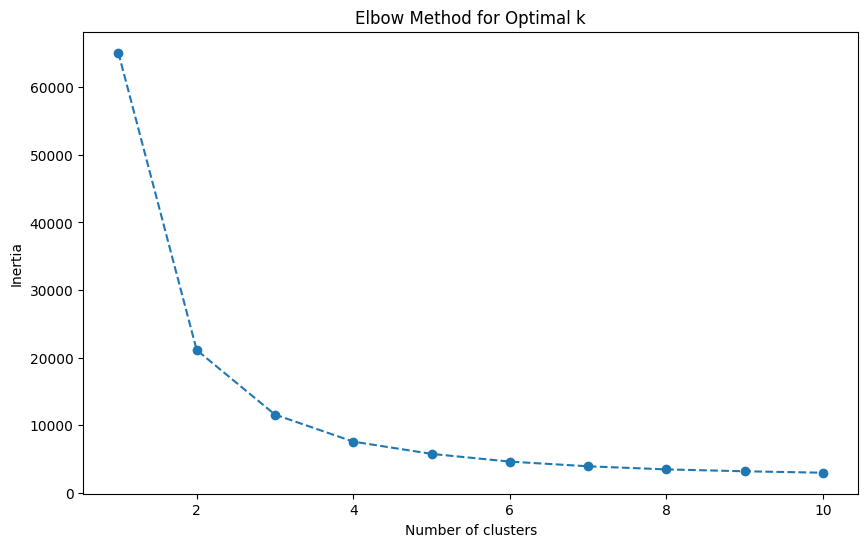

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Elbow method to find the optimal k
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


## Select k=3 as the optimal number of clusters based on the elbow method.

In [6]:
k = 3

# Perform k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the original dataframe
traffic_data['Cluster'] = kmeans.labels_


## Create visualizations for the clusters

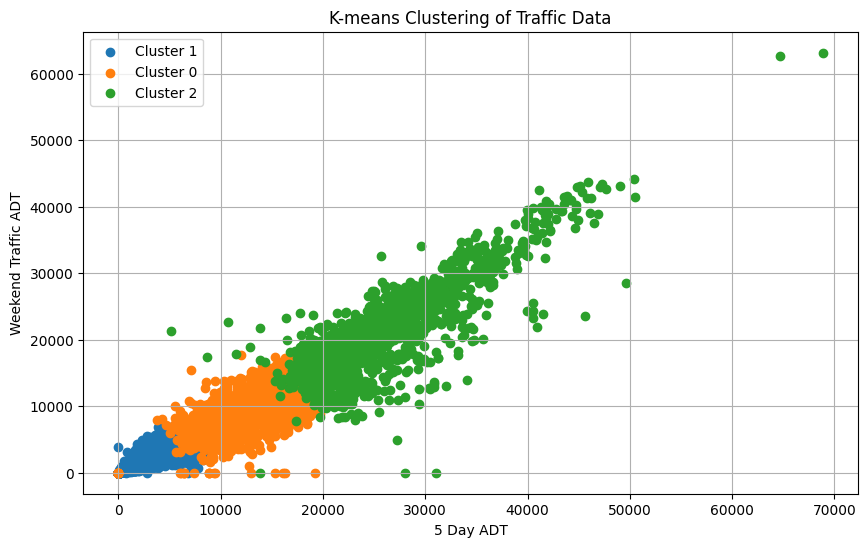

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Scatter plot based on two selected features
plot_columns = ['5 Day ADT', 'Weekend Traffic ADT']

plt.figure(figsize=(10, 6))

# Plot each cluster with a different color
for cluster in traffic_data['Cluster'].unique():
    cluster_data = traffic_data[traffic_data['Cluster'] == cluster]
    plt.scatter(cluster_data[plot_columns[0]], cluster_data[plot_columns[1]], label=f'Cluster {cluster}')

plt.title('K-means Clustering of Traffic Data')
plt.xlabel(plot_columns[0])
plt.ylabel(plot_columns[1])
plt.legend()
plt.grid(True)
plt.show()


## Filter out the outliers to achieve a more polished plot.

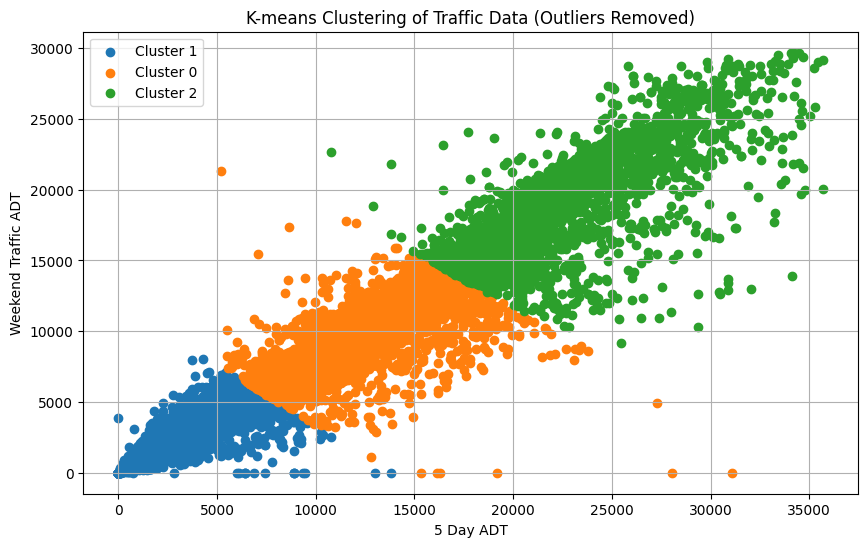

In [8]:
import numpy as np
from scipy import stats

# Calculate Z-scores for the selected columns
z_scores = np.abs(stats.zscore(traffic_data[plot_columns]))

# Define a threshold for Z-score (e.g., 3 standard deviations)
threshold = 3

# Filter rows where any Z-score exceeds the threshold
filtered_data = traffic_data[(z_scores < threshold).all(axis=1)].copy()  # Make a copy to avoid SettingWithCopyWarning

# Now, use filtered_data for K-means clustering
scaled_data = scaler.fit_transform(filtered_data[plot_columns])

# Perform K-means clustering on filtered and scaled data
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)

# Assign cluster labels using .loc to avoid SettingWithCopyWarning
filtered_data.loc[:, 'Cluster'] = kmeans.labels_

# Plotting after removing outliers
plt.figure(figsize=(10, 6))

# Plot each cluster with a different color
for cluster in filtered_data['Cluster'].unique():
    cluster_data = filtered_data[filtered_data['Cluster'] == cluster]
    plt.scatter(cluster_data[plot_columns[0]], cluster_data[plot_columns[1]], label=f'Cluster {cluster}')

plt.title('K-means Clustering of Traffic Data (Outliers Removed)')
plt.xlabel(plot_columns[0])
plt.ylabel(plot_columns[1])
plt.legend()
plt.grid(True)
plt.show()


Based on the graph depicting the k-means clustering of traffic data and the centroids derived from the analysis, it is evident that cluster 2 stands out prominently. This cluster is characterized by roads exhibiting significantly high volumes of vehicle traffic across multiple metrics such as 5 Day ADT, Weekend Traffic ADT, AM Peak Volume, Mid Peak Volume, and PM Peak Volume. The centroids, which represent the average values of these features within each cluster, show that cluster 2 has distinctly higher values compared to clusters 0 and 1.

Given this analysis, it is reasonable to identify cluster 2 as comprising the "traffic hotspots" or roads with the highest volumes of vehicles. These roads likely experience heavy traffic throughout various times and days, making them critical focal points for traffic management strategies and infrastructure development.

By labeling cluster 2 as traffic hotspots, stakeholders and policymakers can prioritize resources such as traffic control measures, infrastructure improvements, and public safety initiatives to effectively manage and mitigate congestion in these high-traffic areas. This targeted approach can lead to more efficient traffic flow, enhanced safety, and improved overall mobility in urban or high-traffic environments.

In [10]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # Inverse transform to get centroids in original scale

# Create a DataFrame to display the centroids
centroid_df = pd.DataFrame(centroids, columns=plot_columns)
centroid_df['Cluster'] = range(0, k)  # Add cluster labels to centroids DataFrame

print("Centroids (Means) of Each Cluster:")
print(centroid_df)

Centroids (Means) of Each Cluster:
      5 Day ADT  Weekend Traffic ADT  Cluster
0  11943.952646          9400.512025        0
1   2601.151901          2038.030851        1
2  22352.329839         18458.440828        2


## Generating Folium Map for Cluster 2 Data

In [12]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Filter data to include only points belonging to Cluster 2
cluster_2_data = filtered_data[filtered_data['Cluster'] == 2]

# Initialize Folium map centered around a location of interest
map_center = [filtered_data['Latitude'].mean(), filtered_data['Longitude'].mean()]  # Centered around mean location
mymap = folium.Map(location=map_center, zoom_start=12)

# Add markers for each point in Cluster 2
marker_cluster = MarkerCluster().add_to(mymap)
for idx, row in cluster_2_data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=f"Cluster 2 - {idx}").add_to(marker_cluster)

# Save the map to an HTML file (optional)
mymap.save('cluster_2_map.html')

# Display the map
mymap
